In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
#from IPython.display import HTML
import math
import json
import time

In [3]:
%load_ext line_profiler

In [4]:
from numba import njit

## Physics model ##
For beggining maximaly simple: just gravitation based model. It calculates the accelaration vector based on position and masses of all bodies

In [5]:
# Integrator interface
class IForceModel:
    def acceleration(self, positions, masses, velocities=None, accelerations=None, t=None):
        raise NotImplementedError

In [6]:
@njit
def gravity_acceleration_newtonian(positions, masses, G):
        N = len(masses)
        acc = np.zeros_like(positions)

        for i in range(N):
            for j in range(i+1, N):
                r_vec = positions[j] - positions[i]
                r2 = np.dot(r_vec, r_vec)
                inv_r3 = 1.0 / (r2 * np.sqrt(r2))
                a = G * r_vec * inv_r3
                acc[i] += masses[j] * a
                acc[j] -= masses[i] * a
        return acc


def acceleration_with_softening(positions, masses, G):
        """
        positions: (N, 2)
        masses: (N,)
        returns: (N, 2)
        """
        N = len(masses)
        acc = np.zeros_like(positions)

        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec) + 1e-9
                acc[i] += G * masses[j] * r_vec / r**3

        return acc

class GravityForce:
    def __init__(self, G=6.67430e-11):
        self.G = G

    def acceleration(self, positions, masses):
        return gravity_acceleration_newtonian(positions, masses, self.G)


In [7]:
class State:
    def __init__(self, n_bodies, dim=2):
        """
        n_bodies : int
            Number of the bodies
        dim : int
            Spatial dimension (2 or 3)
        """
        
        if not isinstance(n_bodies, int) or n_bodies <= 0:
            raise ValueError("n_bodies must be an int bigger than 0")
        if not isinstance(dim, int) or dim <= 0:
            raise ValueError("dim must be an int bigger than 0")
        
        self.n = n_bodies
        self.dim = dim

        self.m = np.zeros((self.n), dtype=np.float64)  # positions
        self.x = np.zeros((self.n, dim), dtype=np.float64)  # positions
        self.v = np.zeros((self.n, dim), dtype=np.float64)  # velocities
        self.a = np.zeros((self.n, dim), dtype=np.float64)  # accelerations

        self.t = 0.0

    def to_dict(self):
        return {
            "m": self.m.copy(),
            "x": self.x.copy(),
            "v": self.v.copy(),
            "a": self.a.copy(),
            "t": self.t,
        }

    @classmethod
    def from_dict(cls, data):
        state = cls(len(data["m"]), dim=data["x"].shape[1])
        state.m = data["m"]
        state.x = data["x"].copy()
        state.v = data["v"].copy()
        state.a = data["a"].copy()
        state.t = data["t"]
        return state

    def copy(self):
        """
        Return a deep copy of this state.

        Returns
        -------
        State
            New State object with copied arrays and time.
        """
        new_state = State(self.n, self.dim)
        new_state.m = self.m.copy()
        new_state.x = self.x.copy()
        new_state.v = self.v.copy()
        new_state.a = self.a.copy()
        new_state.t = self.t
        return new_state

# -------------- Setters --------------
    def set_masses(self, masses):
        """
        Set masses of all bodies in kg.
    
        positions : array, shape (N)
            masses of all bodies.
            N must equal number of bodies.
            Units are kg.
        """
        arr = np.asarray(masses, dtype=np.float64)
    
        if arr.shape != (self.n,):
            raise ValueError(
                f"masses must have shape {(self.n,)}, "
                f"got {arr.shape}"
            )
    
        self.m[:] = arr
    
    def set_positions(self, positions):
        """
        Set absolute positions of all bodies.
    
        positions : array-like, shape (N, dim)
            Cartesian positions of all bodies.
            N must equal number of bodies.
            Units are meters.
        """
        arr = np.asarray(positions, dtype=np.float64)
    
        if arr.shape != (self.n, self.dim):
            raise ValueError(
                f"positions must have shape {(self.n, self.dim)}, "
                f"got {arr.shape}"
            )
    
        self.x[:] = arr
    

    def set_velocities(self, velocities):
        """
        Set velocities of all bodies.
    
        velocities : array-like, shape (N, dim)
            Velocity vectors of all bodies.
            Units are meters per second.
    
        """
        arr = np.asarray(velocities, dtype=np.float64)
    
        if arr.shape != (self.n, self.dim):
            raise ValueError(
                f"velocities must have shape {(self.n, self.dim)}, "
                f"got {arr.shape}"
            )
    
        self.v[:] = arr

    def set_accelerations(self, accelerations):
        """
        Set accelerations of all bodies.
    
        accelerations : array-like, shape (N, dim)
            Acceleration vectors of all bodies.
            Units are meters per second squared.
        """
        arr = np.asarray(accelerations, dtype=np.float64)
    
        if arr.shape != (self.n, self.dim):
            raise ValueError(
                f"accelerations must have shape {(self.n, self.dim)}, "
                f"got {arr.shape}"
            )
    
        self.a[:] = arr

    def set_time(self, t):
        """
        Set absolute simulation time.
    
        t : float
            Simulation time in seconds.
        """
        t = float(t)
    
        if not np.isfinite(t):
            raise ValueError("time must be a finite float")
    
        self.t = t

    def advance_time(self, dt):
        """
        Advance simulation time by a time step.

        dt : float
            Time step in seconds. Must be positive.
        """
        dt = float(dt)
    
        if not np.isfinite(dt) or dt <= 0.0:
            raise ValueError("dt must be a positive finite float")
    
        self.t += dt

# -------------- Getters --------------
    def get_body_state(self, idx):
        """
        Get full state of a single body.
    
        idx : int
            Index of the body.
    
        Returns
        dict
            {
                "m": float,        # mass [kg]
                "x": np.ndarray,   # position, shape (dim,), meters
                "v": np.ndarray,   # velocity, shape (dim,), m/s
                "a": np.ndarray,   # acceleration, shape (dim,), m/s^2
            }
        """
        if idx < 0 or idx >= self.n:
            raise IndexError(f"body index {idx} out of range")
    
        return {
            "m": self.m[idx],
            "x": self.x[idx].copy(),
            "v": self.v[idx].copy(),
            "a": self.a[idx].copy(),
            "t": self.t
        }

    def get_positions(self):
        """
        Get positions of all bodies.
    
        Returns
        -------
        np.ndarray, shape (N, dim)
            Position vectors of all bodies in meters.
            Returned as a view (do not modify).
        """
        return self.x.copy()

    def get_velocities(self):
        """
        Get velocities of all bodies.
    
        Returns
        -------
        np.ndarray, shape (N, dim)
            Velocity vectors of all bodies in m/s.
            Returned as a view (do not modify).
        """
        return self.v.copy()

    def get_accelerations(self):
        """
        Get accelerations of all bodies.
    
        Returns
        -------
        np.ndarray, shape (N, dim)
            Acceleration vectors of all bodies in m/s^2.
            Returned as a view (do not modify).
        """
        return self.a.copy()

    def get_masses(self):
        """
        Get masses of all bodies.
    
        Returns
        -------
        np.ndarray, shape (N,)
            Masses of bodies in kilograms.
            Returned as a view (do not modify).
        """
        return self.m.copy()

    def get_time(self):
        """
        Get current simulation time.
    
        Returns
        -------
        float
            Simulation time in seconds.
        """
        return self.t


        

## Integrator ##

In [8]:
# Integrator interface
class IIntegrator:
    def step(self, state: State, force_model: IForceModel, dt, control_acc=None, control_idx=None):
        raise NotImplementedError

In [9]:
# Verlet integrator
class VelocityVerlet(IIntegrator):
    def step(self, state: State, force_model: IForceModel, dt, control_acc=None, control_idx=None):
        m = state.get_masses()
        x = state.get_positions()
        v = state.get_velocities()
        a = state.get_accelerations()

        # 1) position update
        x_new = x + v*dt + a*(0.5*dt**2)
        # 2) acceleration at NEW positions
        a_new = force_model.acceleration(x_new, m)
        # optional control for thrust later
        # 3) velocity update
        v_new = v + (a + a_new) * (0.5*dt)
        
        state.set_positions(x_new)
        state.set_velocities(v_new)
        state.set_accelerations(a_new)
        
        return state

    def step(self, masses, positions, velocities, accelerations, force_model: IForceModel, dt, control_acc=None, control_idx=None):
        # 1) position update
        x_new = positions + velocities*dt + accelerations*(0.5*dt**2)
        # 2) acceleration at NEW positions
        a_new = force_model.acceleration(x_new, masses)
        # optional control for thrust later
        # 3) velocity update
        v_new = velocities + (accelerations + a_new) * (0.5*dt)
        
        positions = x_new
        velocities = v_new
        accelerations = a_new
        
        return positions, velocities, accelerations

In [10]:
class SymplecticEuler(IIntegrator):
    def step(self, state: State, force_model: IForceModel, dt):
        m = state.get_masses()
        x = state.get_positions()
        v = state.get_velocities()

        a = force_model.acceleration(x, m)
        v_new = v + a * dt
        x_new = x + v_new * dt

        state.set_velocities(v_new)
        state.set_positions(x_new)
        state.set_accelerations(a)

        return state

    def step(self, masses, positions, velocities, accelerations, force_model: IForceModel, dt):
        a_new = force_model.acceleration(positions, masses)
        v_new = velocities + a_new * dt
        x_new = positions + v_new * dt

        positions = x_new
        velocities = v_new
        accelerations = a_new

        return positions, velocities, accelerations

## Environement ##

In [11]:
# Envorinment implementation
class SolarSystemEnv:
    def __init__(self, force_model: IForceModel, integrator: IIntegrator, bodies, dt=60.0):
        """
        bodies : array-like of masses, shape (N,)

        """
        self.dt = dt
        self.force_model = force_model()
        self.integrator = integrator()

        self.bodies = bodies
        self.n_bodies = len(self.bodies[0])
        dim = 2
        
        self.m = np.zeros((self.n_bodies), dtype=np.float64)  # positions
        self.x = np.zeros((self.n_bodies, dim), dtype=np.float64)  # positions
        self.v = np.zeros((self.n_bodies, dim), dtype=np.float64)  # velocities
        self.a = np.zeros((self.n_bodies, dim), dtype=np.float64)  # accelerations
        self.t = 0.0
        
        #self.state = None

        self.m, self.x, self.v, self.a, self.t = self.reset()

    def reset(self):
        #self.state = State(self.n_bodies)

        self.m = self.bodies[0]
        self.x = self.bodies[1]
        self.v = self.bodies[2]
        self.a = self.force_model.acceleration(self.x, self.m)
        self.t = 0.0

        return self.m, self.x, self.v, self.a, self.t

    def step(self):
        self.t += self.dt
        self.x, self.v, self.a = self.integrator.step(
            self.m, self.x, self.v, self.a,
            self.force_model,
            self.dt
        )

        return self.x, self.v, self.a

    def step_state_object(self):
        t = self.state.get_time() + self.dt
        self.state = self.integrator.step(
            self.state,
            self.force_model,
            self.dt
        )
        self.state.set_time(t)

        return self.state

    def reset_state_object(self):
        self.state = State(self.n_bodies)

        m = self.bodies[0]
        x = self.bodies[1]
        v = self.bodies[2]
        a = self.force_model.acceleration(x, m)
        t = 0.0

        self.state.set_masses(m)
        self.state.set_positions(x)
        self.state.set_velocities(v)
        self.state.set_accelerations(a)
        self.state.set_time(t)

        return self.state

## Visualisation ##
### Heliocentric ###
- scale=1.0/1.496e11 (conversion to the au scale)
- no centre body
### Geocentric (i prefer terrracentric) ###
- scale: 1.0/1.496e11 (conversion to the au scale)
- lims: -0.005, 0.005 (to see the moon) or -10, 10 to see other bodies revolve around earth
- centre body: "Earth"
### Jovicentric (Jupiter-centric) ###
- scale: 1.0/6.9911e7 (conversion to the jupiter radius scale)
- lims: -30.0, 30.0 (to see the moons)
- centre body: "Jupiter"


In [12]:
def visualize_trajectories(states, body_names, colors=None, scale=1.0/1.496e11, centre_body=None, trail_length=50,
                         xlim=(-10,10), ylim=(-10,10), interval=50, save_path=None):
    """
    Visualize a precomputed trajectory of bodies with center on the Sun (0,0).

    states : list of dict
        Each dict must contain 'x' (Nx2 array) and 't' (float).
    body_names : list of str
        Names of bodies (length N).
    colors : list of str
        Colors for bodies.
    scale : float
        Scaling factor for positions.
    centre_body : str
        name of the body from body_names list to centre the visualisation around
    trail_length : int
        How many past positions to show in trail.
    xlim, ylim : tuple
        Plot limits.
    interval : int
        Milliseconds between frames.
    save_path : str or None
        If given, saves animation to file (requires ffmpeg).
    """
    colors = colors
    n_bodies = len(body_names)
    if((centre_body is not None) and (centre_body in body_names)):
        centre_body_index = np.where(body_names == centre_body)[0][0]
    else:
        centre_body_index = None

    # TODO: states preproc: scale and offset calc
    
    # Figure setup
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_aspect("equal")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("x (scaled)")
    ax.set_ylabel("y (scaled)")
    ax.set_title("Sol System")
    
    #Scatter objects for bodies positions
    scatters = [ax.scatter([], [], color=colors[i], s=80, label=body_names[i]) 
                for i in range(n_bodies)]

    
    # Time text
    time_text = ax.text(0.02, 0.98, "", transform=ax.transAxes,
                        ha="left", va="top", fontsize=9,
                        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    
    def init():    
        if(centre_body_index is not None):
            centre_body_offset = states[0]['x'][centre_body_index]
        else:
            centre_body_offset = 0
            
        positions = (states[0]['x'] - centre_body_offset) * scale
        i = 0
        for sc in scatters:
            sc.set_offsets([positions[i]])
            i += 1
            
        time_text.set_text(f"t = {states[0]['t']:.1f} s")
        return tuple(scatters) + (time_text,)

    
    def update(frame):
        state = states[frame]
        
        if(centre_body_index is not None):
            centre_body_offset = state['x'][centre_body_index]
        else:
            centre_body_offset = 0
        
        positions = (state['x'] - centre_body_offset) * scale
        t = state['t']

        # Update bodies positions
        for i, name in enumerate(body_names):
            scatters[i].set_offsets([positions[i]])

        # Update time
        time_text.set_text(f"t = {t:.1f} s")
        return tuple(scatters) + (time_text,)

    
    anim = FuncAnimation(fig, update, frames=len(states), init_func=init,
                         blit=False, interval=interval)

    plt.legend()

    if save_path is not None:
        anim.save(save_path, writer="pillow")

    return anim

In [13]:
def plot_static_trajectories(states, body_names, colors=None, scale=1.0/1.496e11, centre_body=None,
                      xlim=(-10,10), ylim=(-10,10)):
    """
    Plot static trajectories of celestial bodies.

    states : list of dict
        Each dict contains 'x' (Nx2 array) and 't' (float)
    body_names : list of str
        Names of bodies
    colors : list of str
        Colors for bodies
    scale : float
        Scale factor for positions (e.g., meters -> AU)
    centre_body : str or None
        Body to center the plot on
    xlim, ylim : tuple
        Plot limits
    """
    colors = colors
    n_bodies = len(body_names)

    # Collect positions for each body
    trajectories = [ [] for _ in range(n_bodies) ]
    for state in states:
        x = state['x']
        if centre_body is not None and centre_body in body_names:
            centre_idx = np.where(np.array(body_names) == centre_body)[0][0]
            offset = x[centre_idx]
        else:
            offset = 0
        positions = (x - offset) * scale
        for i in range(n_bodies):
            trajectories[i].append(positions[i].copy())

    # Convert to arrays
    trajectories = [ np.array(traj) for traj in trajectories ]

    # Plot
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_aspect("equal")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("x (scaled)")
    ax.set_ylabel("y (scaled)")
    ax.set_title("Celestial Trajectories")

    for i, traj in enumerate(trajectories):
        ax.plot(traj[:,0], traj[:,1], color=colors[i], label=body_names[i])

    ax.legend()
    plt.show()

bodies = [
    # Masses
    np.array([
        1.9885e30,      # Sun
        5.972e24,       # Earth
        7.342e22,       # Luna
        6.4171e23,      # Mars
        1.898e27,       # Jupiter
        8.93e22,        # Io
        4.8e22,         # Europa
        1.48e23,        # Ganymede
        1.08e23         # Callisto
    ]),
    # Positions (x, y) in meters
    np.array([
        [0.0, 0.0],                     # Sun
        [1.496e11, 0.0],                # Earth
        [1.496e11 + 3.844e8, 0.0],      # Luna
        [2.279e11, 0.0],                # Mars
        [7.785e11, 0.0],                # Jupiter
        [7.785e11 + 4.22e8, 0.0],       # Io
        [7.785e11 + 6.71e8, 0.0],       # Europa
        [7.785e11 + 1.07e9, 0.0],       # Ganymede
        [7.785e11 + 1.88e9, 0.0]        # Callisto
    ]),
    # Velocities (vx, vy) in m/s
    np.array([
        [0.0, 0.0],                       # Sun
        [0.0, 29783.0],                    # Earth
        [0.0, 29783.0 + 1022.0],           # Luna
        [0.0, 24077.0],                    # Mars
        [0.0, 13070.0],                    # Jupiter
        [0.0, 13070.0 + 17320.0],          # Io
        [0.0, 13070.0 + 13740.0],          # Europa
        [0.0, 13070.0 + 10880.0],          # Ganymede
        [0.0, 13070.0 + 8200.0]            # Callisto
    ]),
    # Names of celestial bodies
    np.array([
        "Sun",
        "Earth",
        "Moon",
        "Mars",
        "Jupiter",
        "Io",
        "Europa",
        "Ganymede",
        "Callisto"
    ]),
    # Colors for visuals
    np.array([
        "orange",     # Sun
        "blue",       # Earth
        "gray",       # Moon (Luna)
        "red",        # Mars
        "darkgoldenrod",      # Jupiter
        "yellow",     # Io
        "lightblue",  # Europa
        "green",      # Ganymede
        "purple"      # Callisto
    ]),
]

anim = visualize_trajectories(
    states=states_dicts,
    body_names=bodies[3],
    colors=bodies[4],
    interval=20,
    centre_body="Earth",
    xlim=(-0.005, 0.005), 
    ylim=(-0.005, 0.005),
    save_path="earth_system.gif"  # None or "solar_system.gif"
)

#HTML(anim.to_jshtml())

### Simulation ###

In [14]:
def run_simulation(force_model: IForceModel, integrator: IIntegrator, bodies, dt=180.0, n_steps=100000, records_len=600):
    states = []
    step = max(1, math.floor(n_steps / records_len))

    env = SolarSystemEnv(force_model, integrator, bodies, dt=dt)
    env_state = env.reset()

    #ship = Spacecraft(dt=60.0)
    #ship.reset(env_state)
    ship_state = None


    for i in range(n_steps):
        x, v, a = env.step()
        #env_state = env.step()
        #ship.step(env_state)
        
        # record every nth step
        if (i % step == 0):
            #states.append(env_state.copy() )
            states.append({"m": env.m,"x": x,"v": v,"a": a,"t": env.t})

    return states

In [15]:
# Some helpers
DAY   = 24 * 3600.0
YEAR  = 365.25 * DAY
AU    = 1.496e11

ORBITAL_PERIODS = {
    # Inner planets
    "Mercury": 87.969 * DAY,
    "Venus":   224.701 * DAY,
    "Earth":   YEAR,
    "Moon":    27.321661 * DAY,
    "Mars":    686.98 * DAY,

    # Asteroid belt reference (optional)
    "Ceres":   1680.0 * DAY,

    # Jupiter system
    "Jupiter": 11.862 * YEAR,
    "Io":      1.769137786 * DAY,
    "Europa":  3.551181 * DAY,
    "Ganymede":7.154553 * DAY,
    "Callisto":16.6890184 * DAY,

    # Saturn system
    "Saturn":  29.457 * YEAR,
    "Titan":   15.945421 * DAY,
    "Rhea":    4.518212 * DAY,
    "Iapetus": 79.3215 * DAY,
    "Dione":   2.736915 * DAY,
    "Tethys":  1.887802 * DAY,
    "Enceladus":1.370218 * DAY,

    # Uranus system
    "Uranus":  84.0205 * YEAR,
    "Titania": 8.705872 * DAY,
    "Oberon":  13.463234 * DAY,
    "Umbriel": 4.144177 * DAY,
    "Ariel":   2.520379 * DAY,
    "Miranda": 1.413479 * DAY,

    # Neptune system
    "Neptune": 164.8 * YEAR,
    "Triton":  5.876854 * DAY,
    "Nereid":  360.1362 * DAY,

    # Dwarf planets
    "Pluto":   248.00 * YEAR,
    "Charon":  6.387230 * DAY,
}

def steps_for_duration(duration_s, dt):
    """
    Number of integration steps for a given physical duration.
    """
    return int(np.ceil(duration_s / dt))

def steps_for_orbits(orbital_period_s, n_orbits, dt):
    """
    orbital_period_s: period of the body (seconds)
    n_orbits: how many full revolutions
    """
    total_time = orbital_period_s * n_orbits
    return int(np.ceil(total_time / dt))

def dt_from_fastest_orbit(orbital_periods_s, samples_per_orbit=2000):
    """
    orbital_periods_s: iterable of orbital periods (seconds)
    samples_per_orbit: 50 (bare minimum), 100+ recommended
    """
    return orbital_periods_s / samples_per_orbit

def compute_dt_from_perihelion(masses, positions, central_body_index=0, safety_factor=0.01, G=6.67430e-11):
    """
    Compute a stable timestep based on perihelion curvature
    for Newtonian gravity with Velocity Verlet.

    Parameters
    ----------
    masses : (N,) ndarray
        Masses of all bodies [kg].
    positions : (N, 2) ndarray
        Current positions of bodies [m].
    central_body_index : int
        Index of dominant mass (Sun, Jupiter, etc.).
    safety_factor : float
        Stability factor (0.005–0.02 recommended).

    Returns
    -------
    dt : float
        Stable timestep in seconds.
    """

    M_c = masses[central_body_index]
    r_c = positions[central_body_index]

    # Distances from central body
    r = np.linalg.norm(positions - r_c, axis=1)

    # Ignore the central body itself
    r = np.delete(r, central_body_index)

    # Smallest perihelion distance
    r_min = np.min(r)

    # Local dynamical timescale
    tau = np.sqrt(r_min**3 / (G * M_c))

    # Stable timestep
    dt = safety_factor * tau

    return dt

def to_json_safe(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, dict):
        return {k: to_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_json_safe(v) for v in obj]
    return obj

def save_states(path, states):
    with open(path, "w") as f:
        json.dump(to_json_safe(states), f)

def load_states(path):
    with open(path, "r") as f:
        states = json.load(f)

    # Optional: convert back to NumPy
    for s in states:
        s["x"] = np.array(s["x"])
        s["v"] = np.array(s["v"])
        s["a"] = np.array(s["a"])
        s["m"] = np.array(s["m"])
    return states

### Sol system simulation ###

In [16]:
bodies = [
    # Masses
    np.array([
        1.9885e30,      # Sun
        5.972e24,       # Earth
        6.4171e23,      # Mars
        1.898e27,       # Jupiter
    ]),
    # Positions (x, y) in meters
    np.array([
        [0.0, 0.0],                     # Sun
        [1.496e11, 0.0],                # Earth
        [2.279e11, 0.0],                # Mars
        [7.785e11, 0.0],                # Jupiter
    ]),
    # Velocities (vx, vy) in m/s
    np.array([
        [0.0, 0.0],                       # Sun
        [0.0, 29783.0],                    # Earth
        [0.0, 24077.0],                    # Mars
        [0.0, 13070.0],                    # Jupiter
    ]),
    # Names of celestial bodies
    np.array([
        "Sun",
        "Earth",
        "Mars",
        "Jupiter",
    ]),
    # Colors for visuals
    np.array([
        "orange",     # Sun
        "blue",       # Earth
        "red",        # Mars
        "darkgoldenrod",      # Jupiter
    ]),
]

#states = run_simulation(GravityForce, VelocityVerlet, bodies, dt=3600.0, n_steps=100000, records_len=1000)
#states_dicts = [state.to_dict() for state in states]
#anim = visualize_trajectories(states=states_dicts,body_names=bodies[3],colors=bodies[4],interval=20,save_path="solar_system.gif")

### Earth - Moon system simulation ###

In [17]:
bodies = [
    # Masses
    np.array([
        1.9885e30,      # Sun
        5.972e24,       # Earth
        7.342e22,       # Luna
    ]),
    # Positions (x, y) in meters
    np.array([
        [0.0, 0.0],                     # Sun
        [1.496e11, 0.0],                # Earth
        [1.496e11 + 3.844e8, 0.0],      # Luna
    ]),
    # Velocities (vx, vy) in m/s
    np.array([
        [0.0, 0.0],                       # Sun
        [0.0, 29783.0],                    # Earth
        [0.0, 29783.0 + 1022.0],           # Luna
    ]),
    # Names of celestial bodies
    np.array([
        "Sun",
        "Earth",
        "Moon",
    ]),
    # Colors for visuals
    np.array([
        "orange",     # Sun
        "blue",       # Earth
        "gray",       # Moon (Luna)
    ]),
]

#states = run_simulation(GravityForce, VelocityVerlet, bodies, dt=60.0, n_steps=100000, records_len=1000)
#states_dicts = [state.to_dict() for state in states]
#anim = visualize_trajectories(states=states_dicts, body_names=bodies[3], colors=bodies[4], interval=20, centre_body="Earth", xlim=(-0.005, 0.005), ylim=(-0.005, 0.005), save_path="earth_system.gif")

### Jupiter - moons system simulation ###

In [18]:
bodies = [
    # Masses
    np.array([
        1.9885e30,      # Sun
        1.898e27,       # Jupiter
        8.93e22,        # Io
        4.8e22,         # Europa
        1.48e23,        # Ganymede
        1.08e23         # Callisto
    ]),
    # Positions (x, y) in meters
    np.array([
        [0.0, 0.0],                     # Sun
        [7.785e11, 0.0],                # Jupiter
        [7.785e11 + 4.22e8, 0.0],       # Io
        [7.785e11 + 6.71e8, 0.0],       # Europa
        [7.785e11 + 1.07e9, 0.0],       # Ganymede
        [7.785e11 + 1.88e9, 0.0]        # Callisto
    ]),
    # Velocities (vx, vy) in m/s
    np.array([
        [0.0, 0.0],                       # Sun
        [0.0, 13070.0],                    # Jupiter
        [0.0, 13070.0 + 17320.0],          # Io
        [0.0, 13070.0 + 13740.0],          # Europa
        [0.0, 13070.0 + 10880.0],          # Ganymede
        [0.0, 13070.0 + 8200.0]            # Callisto
    ]),
    # Names of celestial bodies
    np.array([
        "Sun",
        "Jupiter",
        "Io",
        "Europa",
        "Ganymede",
        "Callisto"
    ]),
    # Colors for visuals
    np.array([
        "orange",     # Sun
        "darkgoldenrod",      # Jupiter
        "yellow",     # Io
        "lightblue",  # Europa
        "green",      # Ganymede
        "purple"      # Callisto
    ]),
]

#states = run_simulation(GravityForce, VelocityVerlet, bodies, dt=10.0, n_steps=100000, records_len=1000)
#states_dicts = [state.to_dict() for state in states]
#anim = visualize_trajectories(states=states_dicts, body_names=bodies[3], colors=bodies[4], scale=1.0/6.9911e7, interval=20, centre_body="Jupiter", xlim=(-30.0, 30.0), ylim=(-30.0, 30.0), save_path="jupiter_system.gif")

### Barycentric adjustments ###

In [19]:
def adjust_barycentric(bodies):
    m = bodies[0].astype(np.float64).copy()
    x = bodies[1].astype(np.float64).copy()
    v = bodies[2].astype(np.float64).copy()
    n = bodies[3].astype(str).copy()
    c = bodies[4].astype(str).copy()
    
    M = np.sum(m)

    # Center of mass position
    R_cm = np.sum(m[:, None] * x, axis=0) / M
    # Shift all positions to barycentric frame
    x -= R_cm
    
    # Total momentum
    P = np.sum(m[:, None] * v, axis=0)
    # Adjust momentum of all bodies to 0 initial momentum
    V_cm = P / M
    v -= V_cm
    
    """
    # Ajust Suns velocity to cancel total momentum
    index_sun = 0
    V_corr = P / m[index_sun]
    P_corr = V_corr * m[index_sun]
    v[index_sun] -= V_corr
    print("Suns P to correctr: ", P_corr)
    print("Suns V to correctr: ", V_corr)

    sum = 0
    for i in range(len(m)):
        P_i = m[i] * v[i]
        print("P_i for ", i, ": ", P_i)
        sum += P_i
    print("P_sum: ", sum)
    """
    
    # Center of Mass
    print("COM position:",np.sum(m[:,None] * x, axis=0) / M)
    # Total Momentum
    print("Total momentum:", np.sum(m[:,None] * v, axis=0))

    barycentric_bodies = []
    barycentric_bodies.append(m)
    barycentric_bodies.append(x)
    barycentric_bodies.append(v)
    barycentric_bodies.append(n)
    barycentric_bodies.append(c)
    
    return barycentric_bodies

### Anything you want ###

In [84]:
# Heliocentric model of the solar system
bodies = [
    # Masses (kg)
    np.array([
        1.9885e30,    # Sun
        3.3011e23,    # Mercury
        4.8675e24,    # Venus
        5.972e24,     # Earth
        6.4171e23,    # Mars
        1.898e27,     # Jupiter
        5.6834e26,    # Saturn
        8.6810e25,    # Uranus
        1.02413e26,   # Neptune
    ]),
    # Positions (x, y) in meters (approx semi-major axes on x-axis)
    np.array([
        [0.0,        0.0],        # Sun
        [5.791e10,   0.0],        # Mercury
        [1.082e11,   0.0],        # Venus
        [1.496e11,   0.0],        # Earth
        [2.279e11,   0.0],        # Mars
        [7.785e11,   0.0],        # Jupiter
        [1.433e12,   0.0],        # Saturn
        [2.872e12,   0.0],        # Uranus
        [4.495e12,   0.0],        # Neptune
    ]),
    # Velocities (vx, vy) in m/s (circular orbit approximation)
    np.array([
        [0.0,     0.0],       # Sun
        [0.0, 47870.0],       # Mercury
        [0.0, 35020.0],       # Venus
        [0.0, 29783.0],       # Earth
        [0.0, 24077.0],       # Mars
        [0.0, 13070.0],       # Jupiter
        [0.0, 9690.0],        # Saturn
        [0.0, 6810.0],        # Uranus
        [0.0, 5430.0],        # Neptune
    ]),
    # Names
    np.array([
        "Sun",
        "Mercury",
        "Venus",
        "Earth",
        "Mars",
        "Jupiter",
        "Saturn",
        "Uranus",
        "Neptune",
    ]),
    # Colors (reasonable defaults for visualization)
    np.array([
        "orange",        # Sun
        "gray",          # Mercury
        "goldenrod",     # Venus
        "blue",          # Earth
        "red",           # Mars
        "darkgoldenrod", # Jupiter
        "green",         # Saturn
        "lightblue",     # Uranus
        "darkblue",     # Neptune
    ]),
]

In [85]:
bodies = adjust_barycentric(bodies)

COM position: [-3.79465155e-08  0.00000000e+00]
Total momentum: [ 0.00000000e+00 -8.23314307e+15]


In [43]:
#dt = compute_dt_from_perihelion(bodies[0], bodies[1], safety_factor=0.001)
#dt = 200
#steps=steps_for_orbits(ORBITAL_PERIODS["Earth"], 6, dt)
#print(dt, steps)

# Performance meassurments #

## State obect not njit ##
%lprun -f SymplecticEuler.step -f GravityForce.acceleration run_simulation(GravityForce, SymplecticEuler, bodies, dt=500, n_steps=10000, records_len=500)

Timer unit: 1e-07 s

Total time: 3.00696 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\1349796720.py
Function: GravityForce.acceleration at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    24                                               def acceleration(self, positions, masses):
    25     10002      38386.0      3.8      0.1          N = len(masses)
    26     10002     469797.0     47.0      1.6          acc = np.zeros_like(positions)
    27                                           
    28                                                   # some of the bodies calculate twice?
    29    100020     283270.0      2.8      0.9          for i in range(N):
    30    450090    1438887.0      3.2      4.8              for j in range(i+1, N):
    31    360072    2837602.0      7.9      9.4                  r_vec = positions[j] - positions[i]
    32    360072    4981807.0     13.8     16.6                  r2 = np.dot(r_vec, r_vec)
    33    360072    3516724.0      9.8     11.7                  inv_r3 = 1.0 / (r2 * np.sqrt(r2))
    34    360072    5528093.0     15.4     18.4                  a = self.G * r_vec * inv_r3
    35    360072    5551324.0     15.4     18.5                  acc[i] += masses[j] * a
    36    360072    5396971.0     15.0     17.9                  acc[j] -= masses[i] * a
    37     10002      26719.0      2.7      0.1          return acc

Total time: 3.59603 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\16930311.py
Function: SymplecticEuler.step at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     2                                               def step(self, state: State, force_model: IForceModel, dt):
     3     10000     127046.0     12.7      0.4          m = state.get_masses()
     4     10000     112882.0     11.3      0.3          x = state.get_positions()
     5     10000     108071.0     10.8      0.3          v = state.get_velocities()
     6                                           
     7     10000   34588666.0   3458.9     96.2          a = force_model.acceleration(x, m)
     8     10000     192900.0     19.3      0.5          v_new = v + a * dt
     9     10000     150053.0     15.0      0.4          x_new = x + v_new * dt
    10                                           
    11     10000     259873.0     26.0      0.7          state.set_velocities(v_new)
    12     10000     204078.0     20.4      0.6          state.set_positions(x_new)
    13     10000     189885.0     19.0      0.5          state.set_accelerations(a)
    14                                           
    15     10000      26833.0      2.7      0.1          return state

%lprun -f VelocityVerlet.step -f GravityForce.acceleration run_simulation(GravityForce, VelocityVerlet, bodies, dt=500, n_steps=10000, records_len=500)

Timer unit: 1e-07 s

Total time: 2.94915 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\1349796720.py
Function: GravityForce.acceleration at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    24                                               def acceleration(self, positions, masses):
    25     10002      38008.0      3.8      0.1          N = len(masses)
    26     10002     479908.0     48.0      1.6          acc = np.zeros_like(positions)
    27                                           
    28                                                   # some of the bodies calculate twice?
    29    100020     278902.0      2.8      0.9          for i in range(N):
    30    450090    1393436.0      3.1      4.7              for j in range(i+1, N):
    31    360072    2767544.0      7.7      9.4                  r_vec = positions[j] - positions[i]
    32    360072    4858351.0     13.5     16.5                  r2 = np.dot(r_vec, r_vec)
    33    360072    3374319.0      9.4     11.4                  inv_r3 = 1.0 / (r2 * np.sqrt(r2))
    34    360072    5497582.0     15.3     18.6                  a = self.G * r_vec * inv_r3
    35    360072    5470445.0     15.2     18.5                  acc[i] += masses[j] * a
    36    360072    5307804.0     14.7     18.0                  acc[j] -= masses[i] * a
    37     10002      25241.0      2.5      0.1          return acc

Total time: 3.55483 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\1960078410.py
Function: VelocityVerlet.step at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     3                                               def step(self, state: State, force_model: IForceModel, dt, control_acc=None, control_idx=None):
     4     10000     125839.0     12.6      0.4          m = state.get_masses()
     5     10000     116316.0     11.6      0.3          x = state.get_positions()
     6     10000     107500.0     10.8      0.3          v = state.get_velocities()
     7     10000     115431.0     11.5      0.3          a = state.get_accelerations()
     8                                           
     9                                                   # 1) position update
    10     10000     304718.0     30.5      0.9          x_new = x + v*dt + a*(0.5*dt**2)
    11                                                   # 2) acceleration at NEW positions
    12     10000   33956101.0   3395.6     95.5          a_new = force_model.acceleration(x_new, m)
    13                                                   # optional control for thrust later
    14                                                   # 3) velocity update
    15     10000     178778.0     17.9      0.5          v_new = v + (a + a_new) * (0.5*dt)
    16                                                   
    17     10000     235773.0     23.6      0.7          state.set_positions(x_new)
    18     10000     196303.0     19.6      0.6          state.set_velocities(v_new)
    19     10000     185604.0     18.6      0.5          state.set_accelerations(a_new)
    20                                                   
    21     10000      25910.0      2.6      0.1          return state

## State List not njit ##
%lprun -f SymplecticEuler.step -f GravityForce.acceleration run_simulation(GravityForce, SymplecticEuler, bodies, dt=500, n_steps=10000, records_len=500)

Timer unit: 1e-07 s

Total time: 3.01304 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\1349796720.py
Function: GravityForce.acceleration at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    24                                               def acceleration(self, positions, masses):
    25     10002      37533.0      3.8      0.1          N = len(masses)
    26     10002     482708.0     48.3      1.6          acc = np.zeros_like(positions)
    27                                           
    28                                                   # some of the bodies calculate twice?
    29    100020     274325.0      2.7      0.9          for i in range(N):
    30    450090    1406666.0      3.1      4.7              for j in range(i+1, N):
    31    360072    2812659.0      7.8      9.3                  r_vec = positions[j] - positions[i]
    32    360072    5057660.0     14.0     16.8                  r2 = np.dot(r_vec, r_vec)
    33    360072    3451274.0      9.6     11.5                  inv_r3 = 1.0 / (r2 * np.sqrt(r2))
    34    360072    5544316.0     15.4     18.4                  a = self.G * r_vec * inv_r3
    35    360072    5593747.0     15.5     18.6                  acc[i] += masses[j] * a
    36    360072    5443336.0     15.1     18.1                  acc[j] -= masses[i] * a
    37     10002      26135.0      2.6      0.1          return acc

Total time: 3.50186 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\3915386506.py
Function: SymplecticEuler.step at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    17                                               def step(self, masses, positions, velocities, accelerations, force_model: IForceModel, dt):
    18     10000   34573892.0   3457.4     98.7          a_new = force_model.acceleration(positions, masses)
    19     10000     186950.0     18.7      0.5          v_new = velocities + a_new * dt
    20     10000     147905.0     14.8      0.4          x_new = positions + v_new * dt
    21                                           
    22     10000      26784.0      2.7      0.1          positions = x_new
    23     10000      26307.0      2.6      0.1          velocities = v_new
    24     10000      24779.0      2.5      0.1          accelerations = a_new
    25                                           
    26     10000      31977.0      3.2      0.1          return positions, velocities, accelerations

%lprun -f VelocityVerlet.step -f GravityForce.acceleration run_simulation(GravityForce, VelocityVerlet, bodies, dt=500, n_steps=10000, records_len=500)

Timer unit: 1e-07 s

Total time: 3.03794 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\1349796720.py
Function: GravityForce.acceleration at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    24                                               def acceleration(self, positions, masses):
    25     10002      40129.0      4.0      0.1          N = len(masses)
    26     10002     478586.0     47.8      1.6          acc = np.zeros_like(positions)
    27                                           
    28                                                   # some of the bodies calculate twice?
    29    100020     282653.0      2.8      0.9          for i in range(N):
    30    450090    1423321.0      3.2      4.7              for j in range(i+1, N):
    31    360072    2883565.0      8.0      9.5                  r_vec = positions[j] - positions[i]
    32    360072    5060810.0     14.1     16.7                  r2 = np.dot(r_vec, r_vec)
    33    360072    3530355.0      9.8     11.6                  inv_r3 = 1.0 / (r2 * np.sqrt(r2))
    34    360072    5661863.0     15.7     18.6                  a = self.G * r_vec * inv_r3
    35    360072    5562364.0     15.4     18.3                  acc[i] += masses[j] * a
    36    360072    5428553.0     15.1     17.9                  acc[j] -= masses[i] * a
    37     10002      27213.0      2.7      0.1          return acc

Total time: 3.55435 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\4110902246.py
Function: VelocityVerlet.step at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    23                                               def step(self, masses, positions, velocities, accelerations, force_model: IForceModel, dt, control_acc=None, control_idx=None):
    24                                                   # 1) position update
    25     10000     311796.0     31.2      0.9          x_new = positions + velocities*dt + accelerations*(0.5*dt**2)
    26                                                   # 2) acceleration at NEW positions
    27     10000   34943571.0   3494.4     98.3          a_new = force_model.acceleration(x_new, masses)
    28                                                   # optional control for thrust later
    29                                                   # 3) velocity update
    30     10000     184390.0     18.4      0.5          v_new = velocities + (accelerations + a_new) * (0.5*dt)
    31                                                   
    32     10000      26303.0      2.6      0.1          positions = x_new
    33     10000      24539.0      2.5      0.1          velocities = v_new
    34     10000      23091.0      2.3      0.1          accelerations = a_new
    35                                                   
    36     10000      29826.0      3.0      0.1          return positions, velocities, accelerations

## State List with njit ##

Timer unit: 1e-07 s

Total time: 0.243492 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\2441892900.py
Function: GravityForce.acceleration at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    40                                               def acceleration(self, positions, masses):
    41     10002    2434923.0    243.4    100.0          return gravity_acceleration_newtonian(positions, masses, self.G)

Total time: 0.418972 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\4110902246.py
Function: VelocityVerlet.step at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    23                                               def step(self, masses, positions, velocities, accelerations, force_model: IForceModel, dt, control_acc=None, control_idx=None):
    24                                                   # 1) position update
    25     10000     801370.0     80.1     19.1          x_new = positions + velocities*dt + accelerations*(0.5*dt**2)
    26                                                   # 2) acceleration at NEW positions
    27     10000    2662273.0    266.2     63.5          a_new = force_model.acceleration(x_new, masses)
    28                                                   # optional control for thrust later
    29                                                   # 3) velocity update
    30     10000     532921.0     53.3     12.7          v_new = velocities + (accelerations + a_new) * (0.5*dt)
    31                                                   
    32     10000      58224.0      5.8      1.4          positions = x_new
    33     10000      40232.0      4.0      1.0          velocities = v_new
    34     10000      39664.0      4.0      0.9          accelerations = a_new
    35                                                   
    36     10000      55034.0      5.5      1.3          return positions, velocities, accelerations


Timer unit: 1e-07 s

Total time: 0.243681 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\2441892900.py
Function: GravityForce.acceleration at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    40                                               def acceleration(self, positions, masses):
    41     10002    2436809.0    243.6    100.0          return gravity_acceleration_newtonian(positions, masses, self.G)

Total time: 0.381705 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\3915386506.py
Function: SymplecticEuler.step at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    17                                               def step(self, masses, positions, velocities, accelerations, force_model: IForceModel, dt):
    18     10000    2639756.0    264.0     69.2          a_new = force_model.acceleration(positions, masses)
    19     10000     524846.0     52.5     13.8          v_new = velocities + a_new * dt
    20     10000     461890.0     46.2     12.1          x_new = positions + v_new * dt
    21                                           
    22     10000      56331.0      5.6      1.5          positions = x_new
    23     10000      41064.0      4.1      1.1          velocities = v_new
    24     10000      38734.0      3.9      1.0          accelerations = a_new
    25                                           
    26     10000      54428.0      5.4      1.4          return positions, velocities, accelerations

In [73]:
%lprun -f SymplecticEuler.step -f GravityForce.acceleration run_simulation(GravityForce, SymplecticEuler, bodies, dt=500, n_steps=10000, records_len=500)

Timer unit: 1e-07 s

Total time: 0.243681 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\2441892900.py
Function: GravityForce.acceleration at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                               def acceleration(self, positions, masses):
    41     10002    2436809.0    243.6    100.0          return gravity_acceleration_newtonian(positions, masses, self.G)

Total time: 0.381705 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\3915386506.py
Function: SymplecticEuler.step at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                               def step(self, masses, positions, velocities, accelerations, force_model: IForceModel, dt):
    18     10000    2639756.0    264.0     69.2          a_new = force_model.acceleration(positions, masses)
    19     10000     524846.0     52.5     13.8          v_new = velocities + a_new * dt
    20     100

In [25]:
%lprun -f SymplecticEuler.step -f GravityForce.acceleration.__wrapped__ run_simulation(GravityForce, VelocityVerlet, bodies, dt=500, n_steps=10000, records_len=500)

Timer unit: 1e-07 s

Total time: 2.94915 s
File: C:\Users\khoma\AppData\Local\Temp\ipykernel_19004\1349796720.py
Function: GravityForce.acceleration at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                               def acceleration(self, positions, masses):
    25     10002      38008.0      3.8      0.1          N = len(masses)
    26     10002     479908.0     48.0      1.6          acc = np.zeros_like(positions)
    27                                           
    28                                                   # some of the bodies calculate twice?
    29    100020     278902.0      2.8      0.9          for i in range(N):
    30    450090    1393436.0      3.1      4.7              for j in range(i+1, N):
    31    360072    2767544.0      7.7      9.4                  r_vec = positions[j] - positions[i]
    32    360072    4858351.0     13.5     16.5                  r2 = np.dot(r_vec, r_vec)
    33    360072    3

In [86]:
#VelocityVerlet
dt=500 
n_steps=1000000
states = run_simulation(GravityForce, VelocityVerlet, bodies, dt=dt, n_steps=n_steps, records_len=500)
states_dicts = states
#states_dicts = [state.to_dict() for state in states]

In [87]:
save_states(f"states(dt{int(dt)}st{int(n_steps/1000)}k).json", states_dicts)

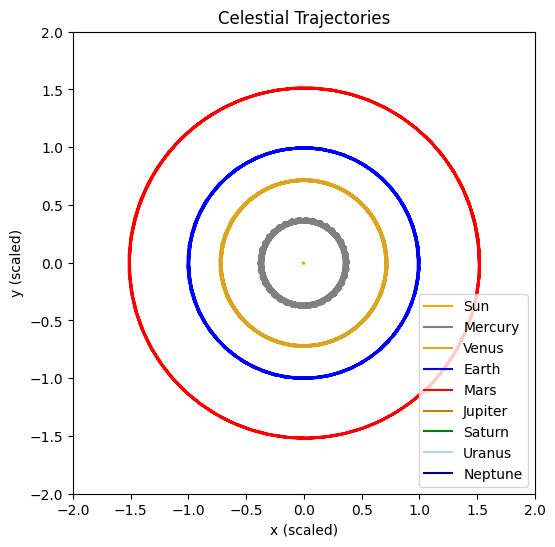

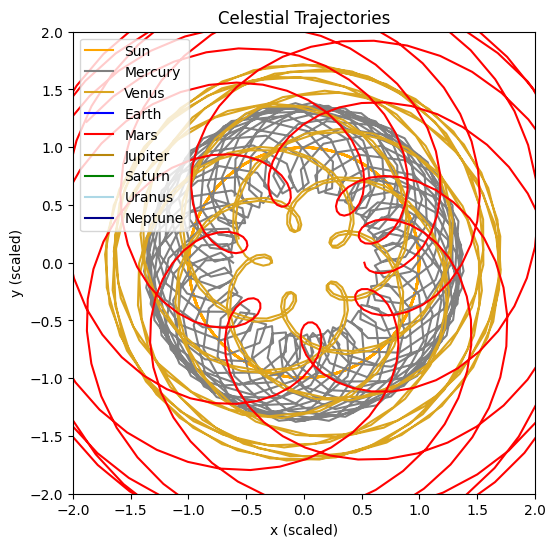

In [88]:
#states_dicts = load_states("states.json")
plot_static_trajectories(states=states_dicts, body_names=bodies[3], colors=bodies[4], xlim=(-2.0, 2.0), ylim=(-2.0, 2.0))
plot_static_trajectories(states=states_dicts, body_names=bodies[3], colors=bodies[4], centre_body="Earth", xlim=(-2.0, 2.0), ylim=(-2.0, 2.0))

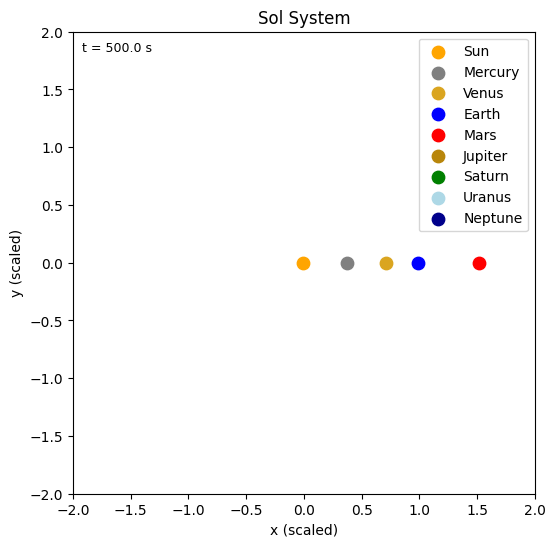

In [47]:
anim = visualize_trajectories(
    states=states_dicts,
    body_names=bodies[3],
    colors=bodies[4],
    interval=40,
    xlim=(-2.0, 2.0), 
    ylim=(-2.0, 2.0),
    save_path="solcentric.gif")

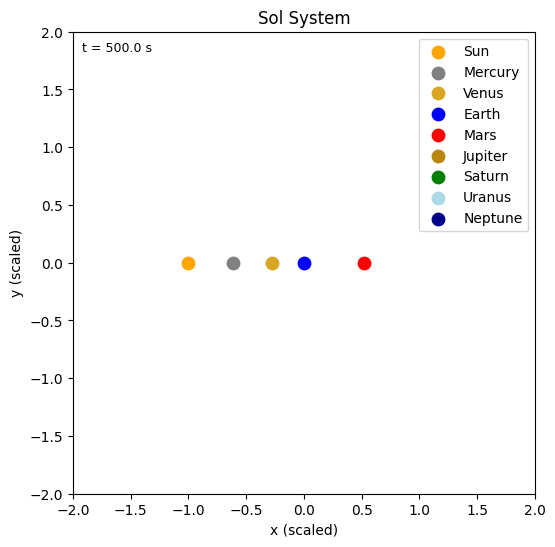

In [48]:
anim = visualize_trajectories(
    states=states_dicts,
    body_names=bodies[3],
    colors=bodies[4],
    interval=40,
    centre_body="Earth",
    xlim=(-2.0, 2.0), 
    ylim=(-2.0, 2.0),
    save_path="terracentric.gif")

In [91]:
bodies = [
    # Masses (kg)
    np.array([
        1.898e30,    
        1.898e30, 
    ]),
    # Positions (x, y) in meters (approx semi-major axes on x-axis)
    np.array([
        [-1.496e11,  0.0], 
        [1.496e11,   0.0],
    ]),
    # Velocities (vx, vy) in m/s (circular orbit approximation)
    np.array([
        [0.0, 15000.0], 
        [0.0, -15000.0],
    ]),
    # Names
    np.array([
        "AntiMercury",
        "Mercury",
    ]),
    # Colors (reasonable defaults for visualization)
    np.array([
        "red",   
        "blue",  
    ]),
]
bodies = adjust_barycentric(bodies)

COM position: [0. 0.]
Total momentum: [0. 0.]


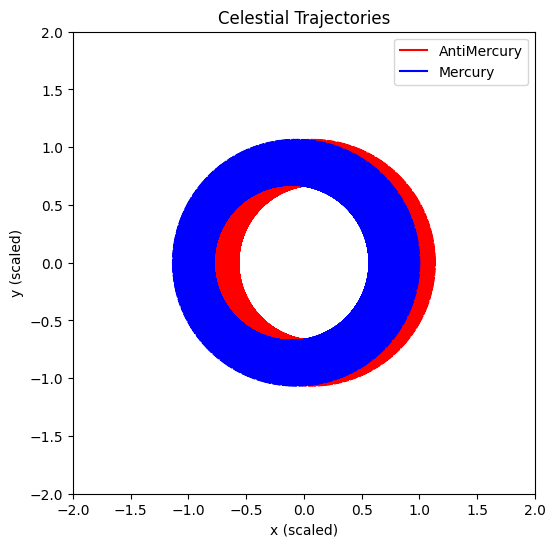

In [92]:
dt=1000
n_steps=10000000
# VelocityVerlet
# SymplecticEuler
states_dicts = run_simulation(GravityForce, SymplecticEuler, bodies, dt=dt, n_steps=n_steps, records_len=500)
#states_dicts = [state.to_dict() for state in states]
plot_static_trajectories(states=states_dicts, body_names=bodies[3], colors=bodies[4], xlim=(-2.0, 2.0), ylim=(-2.0, 2.0))

In [93]:
save_states(f"states_bisystem_euler(dt{int(dt)}st{int(n_steps/1000)}k).json", states_dicts)

In [20]:
bodies = [
    # Masses (kg)
    np.array([
        1.898e30,
        1.898e27,
    ]),
    # Positions (x, y) in meters (approx semi-major axes on x-axis)
    np.array([
        [0.0,  0.0],   
        [1.496e11,   0.0],
    ]),
    # Velocities (vx, vy) in m/s (circular orbit approximation)
    np.array([
        [0.0, 0.0],    
        [0.0, -30000.0], 
    ]),
    # Names
    np.array([
        "AntiMercury",
        "Mercury",
    ]),
    # Colors (reasonable defaults for visualization)
    np.array([
        "red",        # Sun
        "blue",          # Mercury
    ]),
]
bodies = adjust_barycentric(bodies)

COM position: [-1.98847158e-08  0.00000000e+00]
Total momentum: [0. 0.]


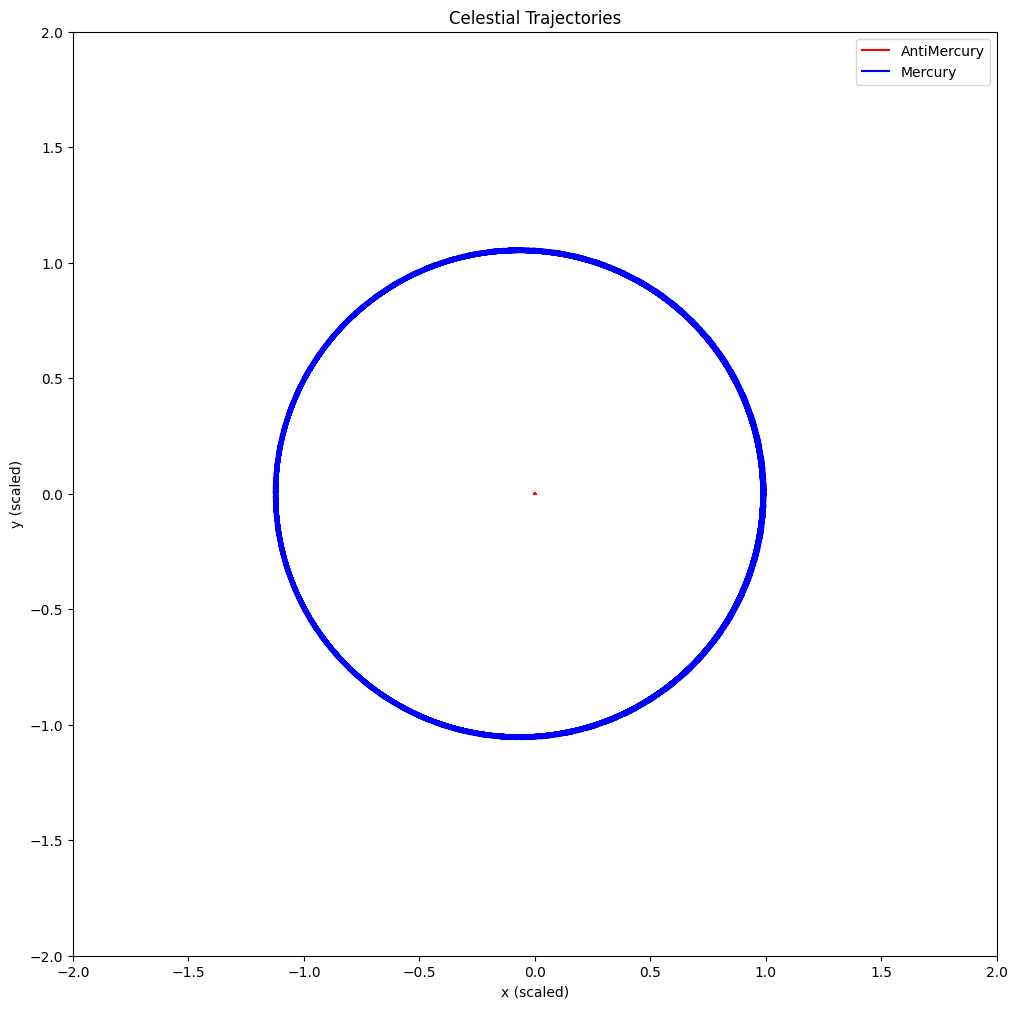

In [23]:
dt=500
n_steps=2000000
# VelocityVerlet
# SymplecticEuler
states = run_simulation(GravityForce, SymplecticEuler, bodies, dt=dt, n_steps=n_steps, records_len=500)
#states_dicts = [state.to_dict() for state in states]
plot_static_trajectories(states=states, body_names=bodies[3], colors=bodies[4], xlim=(-2.0, 2.0), ylim=(-2.0, 2.0))

In [25]:
save_states(f"states_bisystem(dt{int(dt)}st{int(n_steps/1000)}k).json", states)

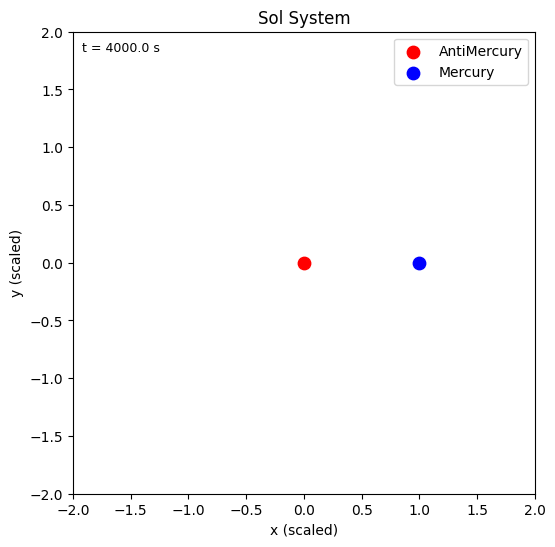

In [40]:
anim = visualize_trajectories(
    states=states_dicts,
    body_names=bodies[3],
    colors=bodies[4],
    interval=40,
    xlim=(-2.0, 2.0), 
    ylim=(-2.0, 2.0),
    save_path="2_body.gif")